<a href="https://colab.research.google.com/github/N-D-0-2/OCT-HCQ-rethinopathy-project/blob/main/OCT_HCQ_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [1]:
!pip install torchmetrics
from google.colab import drive

import os
import cv2 as cv
import albumentations as A

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchmetrics as tm

import sklearn as skl
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

plt.style.use('dark_background')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 5.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


cuda


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/StageUCL/Data/Data_Concat.zip

Archive:  /content/drive/MyDrive/StageUCL/Data/Data_Concat.zip
  inflating: data_concat/1 OL changes inner layers.npy  
  inflating: data_concat/1 OR.npy    
  inflating: data_concat/10 OL.npy   
  inflating: data_concat/10 OR.npy   
  inflating: data_concat/100 OL.npy  
  inflating: data_concat/100 OR.npy  
  inflating: data_concat/101 OL.npy  
  inflating: data_concat/101 OR.npy  
  inflating: data_concat/102 OL drusens.npy  
  inflating: data_concat/102 OR drusens.npy  
  inflating: data_concat/103 OLa epiretinal membrane.npy  
  inflating: data_concat/103 OLb epiretinal membrane.npy  
  inflating: data_concat/103 ORa.npy  
  inflating: data_concat/104 OL.npy  
  inflating: data_concat/104 OR.npy  
  inflating: data_concat/105 OL.npy  
  inflating: data_concat/105 OR.npy  
  inflating: data_concat/106 OLa vitreomacular traction.npy  
  inflating: data_concat/106 OLb vitreomacular traction.npy  
  inflating: data_concat/106 OLc vitreomacular traction.npy  
  inflating: data_concat/10

# 2. Data set

## SRC

In [4]:
class CustomDataset(Dataset):
  #custom dataset class, moddify the getitiem method if you want to change the way the scans are fed
  def __init__(self, image_paths, labels, transform=None):
    self.image_paths = image_paths
    self.labels = torch.from_numpy(np.asarray(labels)).long()
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image = torch.from_numpy(np.load(self.image_paths[idx])).float().permute(2,0,1)
    label = self.labels[idx]
    if self.transform:
        image = self.transform(image)
    return image, label[..., None] # feed all 6 images for each scan       #[2:5,...] only 3 images

def train_val_dataloader(data_path='/content/drive/MyDrive/StageUCL/Data/', batch_size=32, test_size=0.2, n_folds=5, seed=42, resample=False,display=False):
  # Takes the pre-formated data from a file, to create the test loader, and the train and test loaders for each fold of the k-folds. Use resample to resample unbalanced classes in the train set.

  x, y, x_test, y_test = np.load(data_path + 'x.npy'), np.load(data_path + 'y.npy'), np.load(data_path + 'x_test.npy'), np.load(data_path + 'y_test.npy')
  test_loader = DataLoader(CustomDataset(x_test, y_test, None), batch_size=batch_size, shuffle=False)

  train_folds, val_folds = [], []
  skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
  for fold, (train_ind, val_ind) in enumerate(skf.split(x, y)):
    x_train, x_val = x[train_ind], x[val_ind]
    y_train, y_val = y[train_ind], y[val_ind]

    if resample == True:
      class_freqs = [1-(np.sum(y_train)/len(y_train)),np.sum(y_train)/len(y_train)]
      print(f'Fold {fold} class frequencies\n0 : {class_freqs[0]:.3g} | 1: {class_freqs[1]:.3g}\nClass sampling weights\n0 : {1/class_freqs[0]:.3g} | 1: {1/class_freqs[1]:.3g}')
      weights = [1/class_freqs[label] for label in y_train]
      train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(y_train), replacement=True)
    else:
      train_sampler = None

    train_folds.append(DataLoader(CustomDataset(x_train, y_train, None), batch_size, sampler=train_sampler, shuffle=True if not(resample) else False))
    val_folds.append(DataLoader(CustomDataset(x_val, y_val, None), batch_size, shuffle=False))

    if display == True:
      if fold == 0:
        fig, ax = plt.subplots(n_folds,3, figsize=(20,20))
      (l_train, n_train) = np.unique(y_train, return_counts=True)
      print(f'Train set: {np.sum(n_train)} elements, {100*n_train[1]/np.sum(n_train):.4g}% of deseased cases')
      print("#"*220)
      if fold == 4:
        print("."*50)
        (l_val, n_val), (l_test, n_test) = np.unique(y_val, return_counts=True), np.unique(y_test, return_counts=True)
        print(f'Val set: {np.sum(n_val)} elements, {100*n_val[1]/np.sum(n_val):.4g}% of deseased cases')
        print(f'Test set: {np.sum(n_test)} elements, {100*n_test[1]/np.sum(n_test):.4g}% of deseased cases')

      k=np.random.randint(3,batch_size)
      for i in range(3):
        train_imgs, train_labels = next(iter(train_folds[fold]))
        ax[fold,i].imshow(train_imgs[k][0,...], cmap='gray') , ax[fold,i].set_title(f'Train: {train_labels[k][0]}'), ax[fold,i].axis('off')
  if display:
    plt.show()

  return train_folds, val_folds, test_loader

## Main

Fold 0 class frequencies
0 : 0.817 | 1: 0.183
Class sampling weights
0 : 1.22 | 1: 5.45
Train set: 420 elements, 18.33% of deseased cases
############################################################################################################################################################################################################################
Fold 1 class frequencies
0 : 0.817 | 1: 0.183
Class sampling weights
0 : 1.22 | 1: 5.45
Train set: 420 elements, 18.33% of deseased cases
############################################################################################################################################################################################################################
Fold 2 class frequencies
0 : 0.817 | 1: 0.183
Class sampling weights
0 : 1.22 | 1: 5.45
Train set: 420 elements, 18.33% of deseased cases
################################################################################################################################################

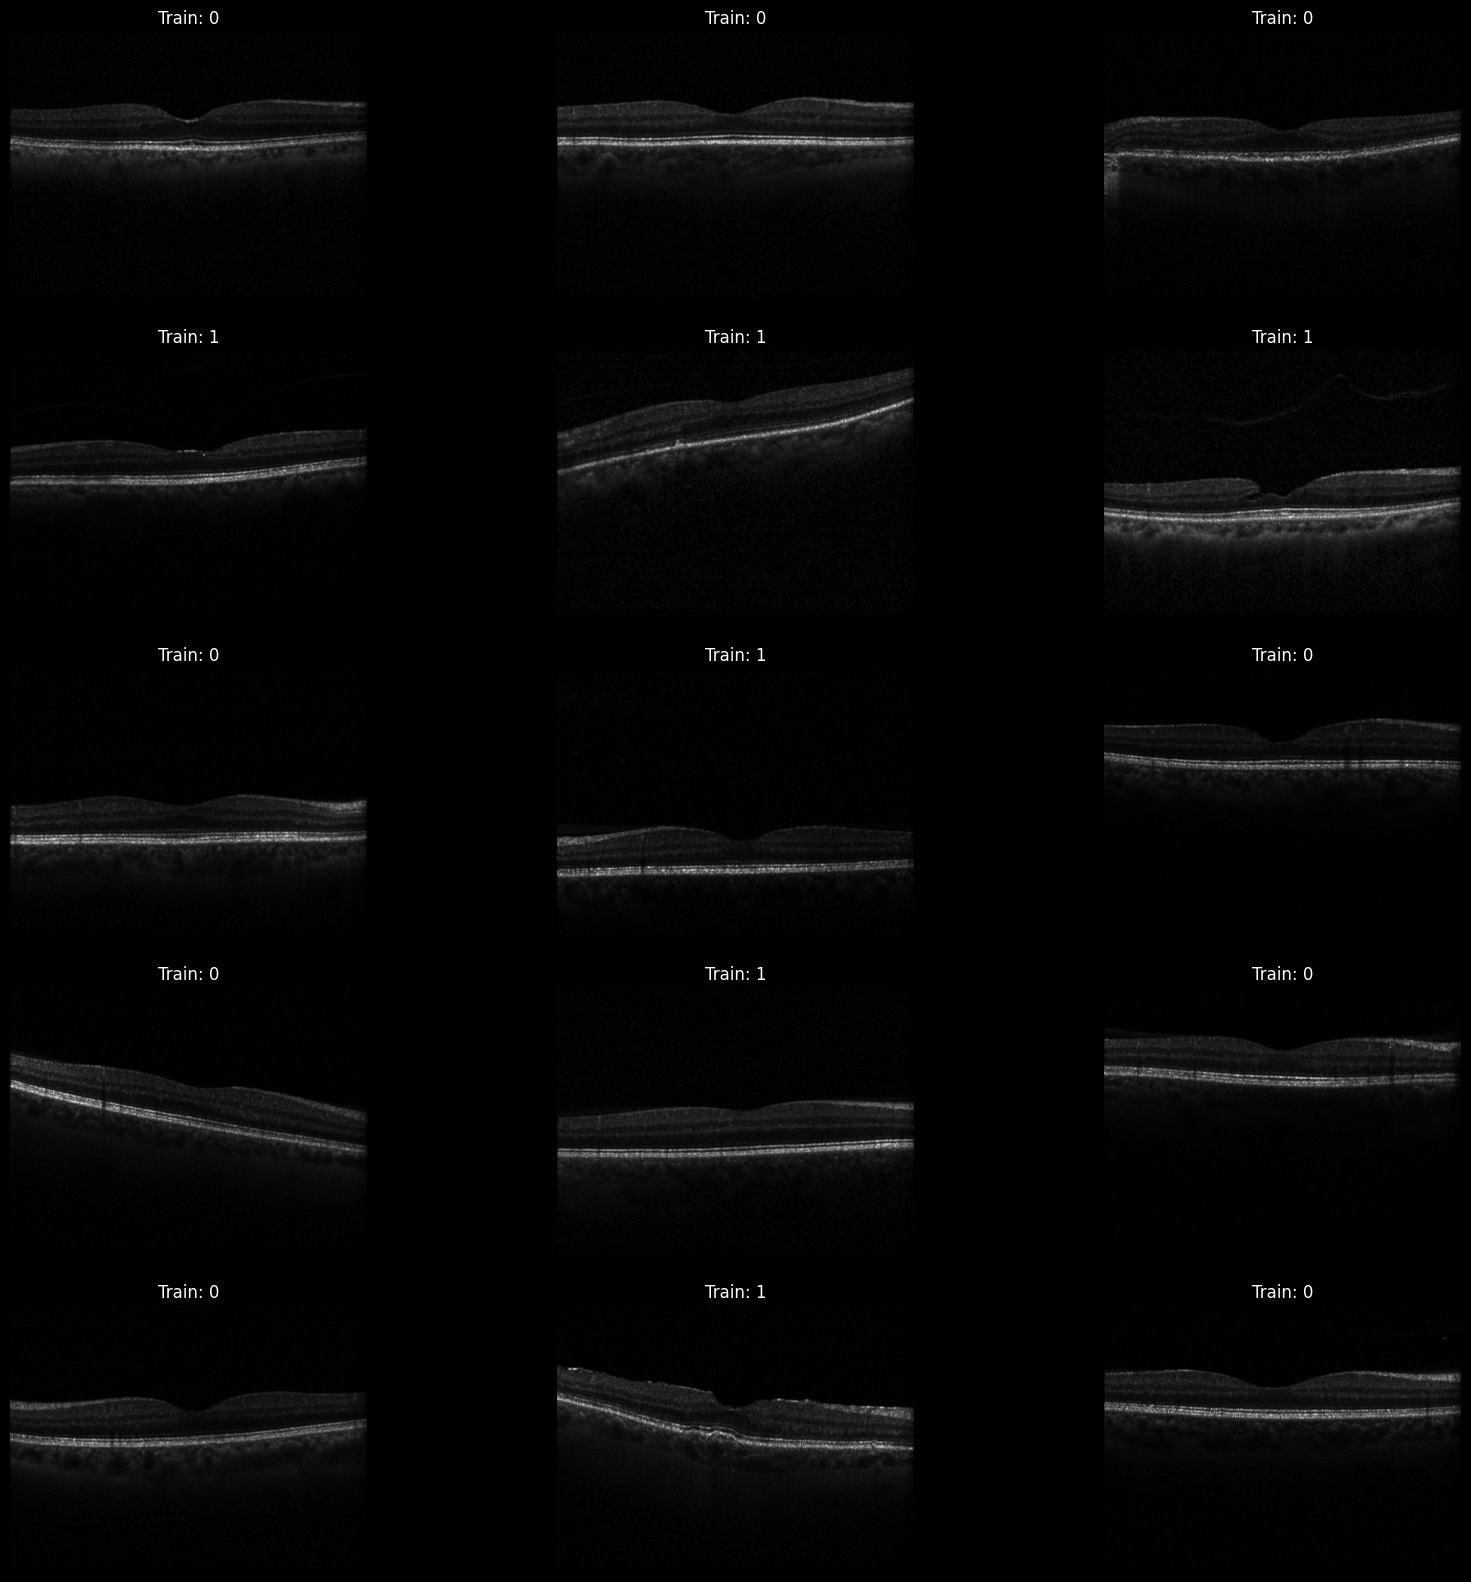

In [5]:
batch_size  = 16
n_folds = 5
train_folds, val_folds, test_loader = train_val_dataloader(n_folds=n_folds, batch_size=batch_size, resample=True, display=True)

# 3. Model Setup

## SRC

In [10]:
def init_model(folder_path, name, n_epochs, load_checkpoint, n_checkpoint, change_learning_rate, learning_rate):
  # Creates the model, initializer and training history for each fold or load a checkpoint from a previous training.
  # If loading a checkpoint, use arguments change learning rate and learning_rate to change the learning rate if necessary.
  # don't forget to change the layers in the optimizer when finetuning specific layers or when changing the structure of the model.
  models_list, optimizers_list, checkpoints_list, loss_list = [], [], [], []
  epoch_offset = n_checkpoint if load_checkpoint else 0
  history = {'train':{'train_loss':np.zeros(n_epochs+epoch_offset), 'train_spec100':np.zeros(n_epochs+epoch_offset), 'train_spec90':np.zeros(n_epochs+epoch_offset), 'train_spec80':np.zeros(n_epochs+epoch_offset), 'train_AUC':np.zeros(n_epochs+epoch_offset)},
                      'val': {'val_loss':np.zeros(n_epochs+epoch_offset), 'val_spec100':np.zeros(n_epochs+epoch_offset), 'val_spec90':np.zeros(n_epochs+epoch_offset), 'val_spec80':np.zeros(n_epochs+epoch_offset), 'val_AUC':np.zeros(n_epochs+epoch_offset)}}

  for fold in range(n_folds):
    models_list.append(ResNet_Ensemble_v2().to(device))
    optimizers_list.append(torch.optim.Adam(list(models_list[fold].base_model.fc.parameters()) + list(models_list[fold].fc.parameters()),
                           lr=learning_rate))

    if load_checkpoint : # Load a checkpoint. The metrics history is restaured and will take on from the last epoch
      checkpoints_list.append(torch.load(os.path.join(folder_path, f'{name}_f{fold}_check{n_checkpoint}.pth')))
      models_list[fold].load_state_dict(checkpoints_list[fold]['model_state_dict'])
      optimizers_list[fold].load_state_dict(checkpoints_list[fold]['optimizer_state_dict'])
      loss_list.append(checkpoints_list[fold]['history']['train']['train_loss'])

      if change_learning_rate :
        for param_group in optimizers_list[fold].param_groups:
          param_group['lr'] = learning_rate

  if load_checkpoint:
    for phase in history:
      for metric in history[phase]:
        history[phase][metric][:epoch_offset] = checkpoints_list[0]['history'][phase][metric][:epoch_offset]

  return models_list, optimizers_list, checkpoints_list, loss_list, history, epoch_offset


## Models  !!(don't forget to change the model AND the parameters in the optimizer when switching between models)!! ##

# These models use a resnet50 pre-trained on ImageNet. The fully connected layer is modified to fit the problem and the data.

class ResNet_Ensemble_v1(nn.Module):
  # This model runs ResNet with the same image on all 3 channels, for each image (6 times) and concatenates the outputs.
  # We then combine the outputs using average pooling
  def __init__(self):
    super().__init__()
    self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for param in self.base_model.parameters():
      param.requires_grad = False   # we first only train the new fully connected layer

    n_features = self.base_model.fc.in_features
    self.base_model.fc = nn.Sequential(nn.Linear(n_features, 256),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(256, 1),
                                nn.Sigmoid())
    self.out_pool = nn.AdaptiveAvgPool1d(1)

  def forward(self, input):
    x_list = [self.base_model(torch.cat([input[:,i:i+1,...]]*3, dim=1)) for i in range(input.shape[1])]
    x_cat = torch.cat(x_list, dim=1).unsqueeze(1)
    output = self.out_pool(x_cat).squeeze(1)
    return output

class ResNet_Ensemble_v2(nn.Module):
  # This model runs ResNet50 on all 6 images just like the v1, but concatenates the feature maps with 256 features each.
  # The feature maps are then used togeither using linear layers, dropout, Relu and sigmoid.
  def __init__(self):
    super().__init__()
    self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for param in self.base_model.parameters():
      param.requires_grad = False

    n_features = self.base_model.fc.in_features
    self.base_model.fc = nn.Sequential(nn.Linear(n_features, 256),
                                nn.ReLU(),
                                nn.Dropout(0.5))

    self.fc = nn.Sequential(nn.Linear(256*6,256), # fc layer that links the 6 feature maps
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(256,1),
                            nn.Sigmoid())

  def forward(self, input):
    x_list = [self.base_model(torch.cat([input[:,i:i+1,...]]*3, dim=1)) for i in range(input.shape[1])] # input[:,i%6:(i+4)%6,...]]
    x_cat = torch.cat(x_list, dim=1).unsqueeze(1)
    output = self.fc(x_cat).squeeze(1)
    return output

class ResNet_Ensemble_v3(nn.Module):
  # A similar approach where we only run the ResNet twice, feeding 3 of the 6 images at once (to reduce computation time)
  def __init__(self):
    super().__init__()
    self.base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for param in self.base_model.parameters():
      param.requires_grad = False

    n_features = self.base_model.fc.in_features
    self.base_model.fc = torch.nn.Identity()

    self.new_fc1 = nn.Sequential(nn.Linear(n_features, 256), nn.ReLU(), nn.Dropout(0.5))
    self.new_fc2 = nn.Sequential(nn.Linear(n_features, 256), nn.ReLU(), nn.Dropout(0.5))
    self.f_out = nn.Linear(512,1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    x1 = self.new_fc1(self.base_model(input[:, 2:5, :, :]))
    x2 = self.new_fc1(self.base_model(input[:, [0,1,5], :, :]))
    x_cat = torch.cat([x1,x2], dim=1).unsqueeze(1)
    output = self.sigmoid(self.f_out(x_cat).squeeze(1))
    return output

class VIT_Ensemble(nn.Module):
    # This model runs ViT on all 6 images, concatenates the feature maps (class token embeddings)
    # and processes them through linear layers, dropout, ReLU, and sigmoid.

    def __init__(self):
        super().__init__()
        self.base_model = models.vit_b_16(weights = models.ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Replace the classification head
        n_features = self.base_model.heads.head.in_features
        self.base_model.heads = nn.Sequential(nn.Linear(n_features, 256),
                                              nn.ReLU(),
                                              nn.Dropout(0.5))

        # Fully connected layers to combine the features from the 6 images
        self.fc = nn.Sequential(nn.Linear(256*6, 256),  # fc layer that links the 6 feature maps
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(256, 1),
                                nn.Sigmoid())

    def forward(self, input):

        input = torch.nn.functional.interpolate(input, size=(224, 224))
        # Loop through each image in the batch
        x_list = [self.base_model(torch.cat([input[:, i:i+1, ...]]*3, dim=1)) for i in range(input.shape[1])]
        x_cat = torch.cat(x_list, dim=1)

        output = self.fc(x_cat)
        return output

class ResNet_X_D(nn.Module):
  # Tests with other models
  def __init__(self):
    super().__init__()
    self.base_model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
    for param in self.base_model.parameters():
      param.requires_grad = False

    n_features = self.base_model.fc.in_features
    self.base_model.fc = nn.Sequential(nn.Linear(n_features, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 1), nn.Sigmoid())
    self.base_model.to(device)

  def forward(self, input):
    output = self.base_model(input)
    return output


## Custom metric  ##

class SpecificityAtFixedRecall():
  def __init__(self, min_recall):
    self.min_recall = min_recall

  def __call__(self, outputs, targets):
    if isinstance(outputs, torch.Tensor):
      outputs = outputs.cpu().numpy()
    if isinstance(targets, torch.Tensor):
      targets = targets.cpu().numpy()

    fpr, tpr, thresholds = roc_curve(targets, outputs)
    idx = np.argmin(np.abs(tpr-self.min_recall))
    return(1-fpr[idx], thresholds[idx])




## Main

In [59]:
# setup the training and or load a model from checkpoint

folder_path = '/content/drive/MyDrive/StageUCL/Models/ResNet Run 1 /bin'  # folder for checkpoints

##    Hyper parametters     ##
n_epochs = 0
learning_rate = 0.000001

##  Load a model checpoint  ##
load_checkpoint = True
change_learning_rate = True
name = 'Resnet_Ensemble_v2'
n_checkpoint = 39  # epoch of the checkpoint to load

# note : file name = f'{name}_f{fold}_check{n_checkpoint}.pth'

## Training settings ##
save_checkpoints = False
model_performance_analysis = True   # AUC curve and confusion matrix at 90% recall, ploted after each epoch
fold_performance_analysis = False   # AUC curve and confusion matrix at 90% recall, ploted for each fold

## loss and metrics ##
criterion = torch.nn.BCEWithLogitsLoss().to(device)
metrics_list = {
    'loss': torch.nn.BCEWithLogitsLoss().to(device),
    'spec100': SpecificityAtFixedRecall(min_recall=1),
    'spec80': SpecificityAtFixedRecall(min_recall=0.8),
    'spec90': SpecificityAtFixedRecall(min_recall=0.9),
    'AUC': tm.AUROC(task='binary').to(device)
}

models_list, optimizers_list, checkpoints_list, loss_list, history, epoch_offset = init_model(folder_path, name, n_epochs, load_checkpoint, n_checkpoint, change_learning_rate, learning_rate)

<ipython-input-10-63a599fab2f7>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoints_list.append(torch.load(os.path.join(folder_path, f'{name}_f{fold}_check{n_check

In [ ]:
 # Freeze or activate the layers

for model in models_list:

  for param in model.layer3.parameters():
    param.requires_grad = True
  for param in model.layer4.parameters():
    param.requires_grad = True
  for param in model.fc.parameters():
    param.requires_grad = True

# 4. Model Training

## SRC

In [51]:
def train_epochs(model, train_loader, optimizer, metrics_list, device):
  # Trains the model and calculates the metrics for one epoch.
  print('train')
  criterion = torch.nn.BCEWithLogitsLoss().to(device)
  outputs_concat, targets_concat = [], []
  model.train()
  metrics_results = {metric: 0 for metric in metrics_list}
  #forward
  for i, (img_batch, target_batch) in enumerate(tqdm(train_loader)):
    img_batch, target_batch = img_batch.to(device), target_batch.to(device)
    optimizer.zero_grad()
    outputs = model(img_batch)
    loss = criterion(outputs, target_batch.float())
    loss.backward()
    optimizer.step()
    outputs_concat.append(outputs.detach()) , targets_concat.append(target_batch.to(device))

  outputs_concat = torch.cat(outputs_concat).cpu().numpy()
  targets_concat = torch.cat(targets_concat).cpu().numpy()
  return outputs_concat, targets_concat

def validate_epochs(model, val_loader, metrics_list, device):
  # Runs the model on the test set and calculates the metrics.
  outputs_concat, targets_concat = [], []
  model.eval()
  metrics_results = {metric: 0 for metric in metrics_list}
  with torch.no_grad():
    for i, (img_batch, target_batch) in enumerate(val_loader):
      img_batch, target_batch = img_batch.to(device), target_batch.to(device)
      outputs = model(img_batch)
      outputs_concat.append(outputs.detach()) , targets_concat.append(target_batch.to(device))

  outputs_concat = torch.cat(outputs_concat).cpu().numpy()
  targets_concat = torch.cat(targets_concat).cpu().numpy()
  return outputs_concat, targets_concat

def epoch_display(history):
  # Displays the metrics for an epoch.
    for phase in history:
      print(f'/ / /{phase}/ / /', end=' ')
      for metric in history[phase]:
        print(f'- {metric} {history[phase][metric][epoch+epoch_offset]:.4g}', end=' ')
    print('\n')

def fold_performance(model, val_dataset, threshold=0.5):
  # Traces the AUC and the confusion matix for a fold at a certain epoch.
  outputs, targets = [], []
  model.eval()
  with torch.no_grad():
    for x_batch, y_batch in val_dataset:
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      outputs.append(model(x_batch))
      targets.append(y_batch)
  outputs, targets = torch.cat(outputs).cpu().numpy(), torch.cat(targets).cpu().numpy()
  print(outputs.shape, targets.shape)

  cm = confusion_matrix(targets, outputs > threshold)
  fpr, tpr, thresholds = roc_curve(targets, outputs)

  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  sns.heatmap(cm, ax=ax[0], annot=True, fmt="d")
  ax[0].set_title(f'Confusion Matrix, Threshold = {threshold}')
  ax[0].set_xlabel('Predicted Labels')
  ax[0].set_ylabel('True Labels')

  ax[1].plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
  ax[1].plot([0, 1], [0, 1], '--', color='red')
  for i in range(0,len(thresholds),4):
    ax[1].text(fpr[i], tpr[i], thresholds[i])
  ax[1].set_xlabel('False Positive Rate')
  ax[1].set_ylabel('True Positive Rate')
  ax[1].set_title('ROC Curve')
  ax[1].legend(loc="lower right")

  plt.tight_layout()
  plt.show()


def model_performance(models_list, val_folds, threshold=0.5, device='cuda'):
  # Traces the AUC and the confusion matrix for the output of all 5 at once. The output of each fold is concatenated to the others.
    out_hist, targ_hist = [], []
    for model, val_loader in zip(models_list, val_folds):
        model.eval()
        model = model.to(device)  # Move model to the specified device
        for input_batch, target_batch in val_loader:
            input_batch = input_batch.to(device)  # Move input data to the same device
            output = model(input_batch)
            out_hist.append(output.detach())
            targ_hist.append(target_batch.to(device))

    out_hist = torch.cat(out_hist).cpu().numpy()
    targ_hist = torch.cat(targ_hist).cpu().numpy()

    cm = confusion_matrix(targ_hist, out_hist > threshold)
    fpr, tpr, thresholds = roc_curve(targ_hist, out_hist)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(cm, ax=ax[0], annot=True, fmt="d")
    ax[0].set_title(f'Confusion Matrix, Threshold = {threshold}')
    ax[0].set_xlabel('Predicted Labels')
    ax[0].set_ylabel('True Labels')

    ax[1].plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
    ax[1].plot([0, 1], [0, 1], '--', color='red')
    for i in range(0, len(thresholds), 10):
        ax[1].text(fpr[i], tpr[i], '{:.2f}'.format(thresholds[i]))
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

def epoch_analysis(outputs_concat, targets_concat, metrics_list, display=False, device=device):
  metrics_results = {metric: 0 for metric in metrics_list}
  outputs_concat = torch.tensor(outputs_concat, dtype=torch.float32, device=device)
  targets_concat = torch.tensor(targets_concat, dtype=torch.float32, device=device)

  for metric in metrics_list:
    result = metrics_list[metric](outputs_concat, targets_concat.float() if metric == 'loss' else targets_concat.int())
    if isinstance(result, tuple):
      metrics_results[metric], threshold = result
    else:
      metrics_results[metric] = result.item()


  if display:
    cm = confusion_matrix(targets_concat.cpu().numpy(), (outputs_concat > threshold).cpu().numpy())
    fpr, tpr, thresholds = roc_curve(targets_concat.cpu().numpy(), outputs_concat.cpu().numpy())

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(cm, ax=ax[0], annot=True, fmt="d")
    ax[0].set_title(f'Confusion Matrix, Threshold = {threshold}')
    ax[0].set_xlabel('Predicted Labels')
    ax[0].set_ylabel('True Labels')

    ax[1].plot(fpr, tpr, label=f'ROC curve (area = {auc(fpr, tpr):.2f})')
    ax[1].plot([0, 1], [0, 1], '--', color='red')
    for i in range(0, len(thresholds), 10):
        ax[1].text(fpr[i], tpr[i], '{:.2f}'.format(thresholds[i]))
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()
  return(metrics_results)



## Main

############################################################################################################## Epoch 57 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.46it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 57 :


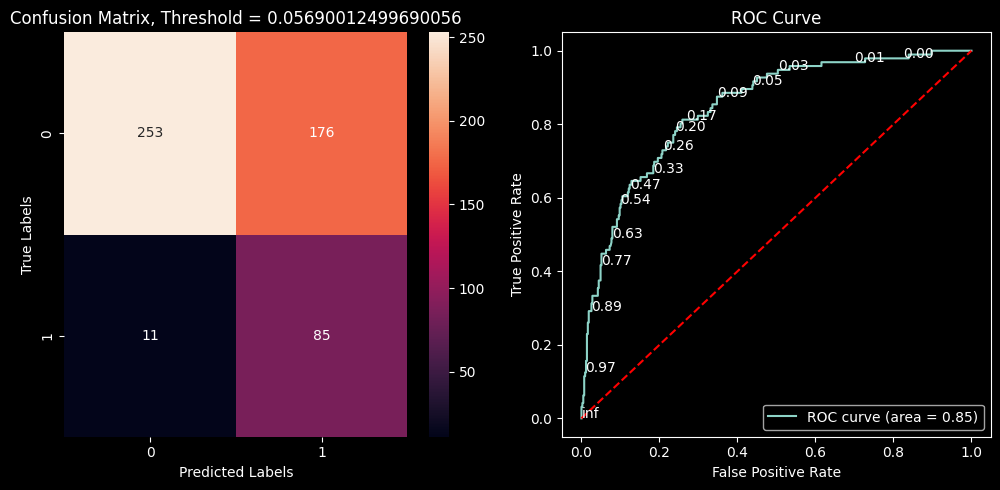

/ / /train/ / / - train_loss 0.5826 - train_spec100 0.006464 - train_spec90 0.8273 - train_spec80 0.9206 - train_AUC 0.9296 / / /val/ / / - val_loss 0.7226 - val_spec100 0.1026 - val_spec90 0.5897 - val_spec80 0.7459 - val_AUC 0.846 

############################################################################################################## Epoch 58 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.35it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 58 :


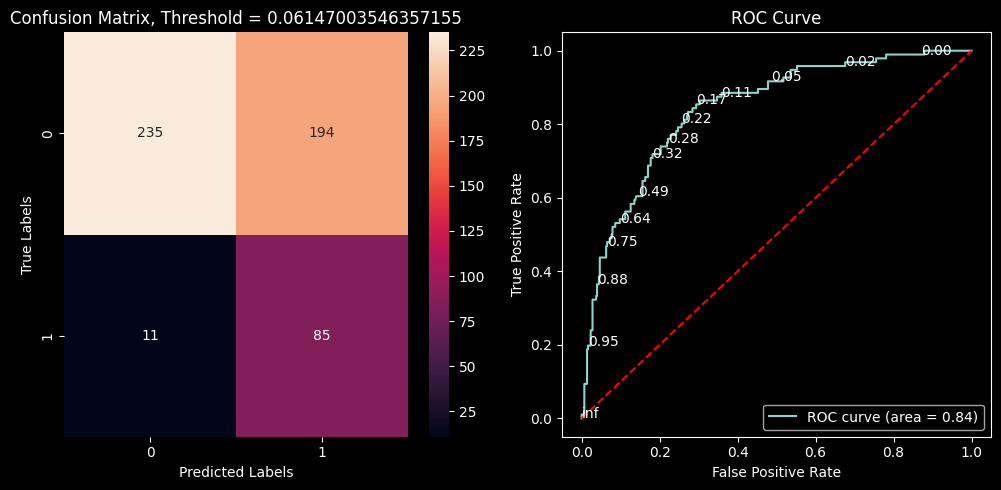

/ / /train/ / / - train_loss 0.5839 - train_spec100 0.01113 - train_spec90 0.7913 - train_spec80 0.9137 - train_AUC 0.9246 / / /val/ / / - val_loss 0.7303 - val_spec100 0.1212 - val_spec90 0.5478 - val_spec80 0.7436 - val_AUC 0.8419 

############################################################################################################## Epoch 59 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


5 fold performance , epoch 59 :


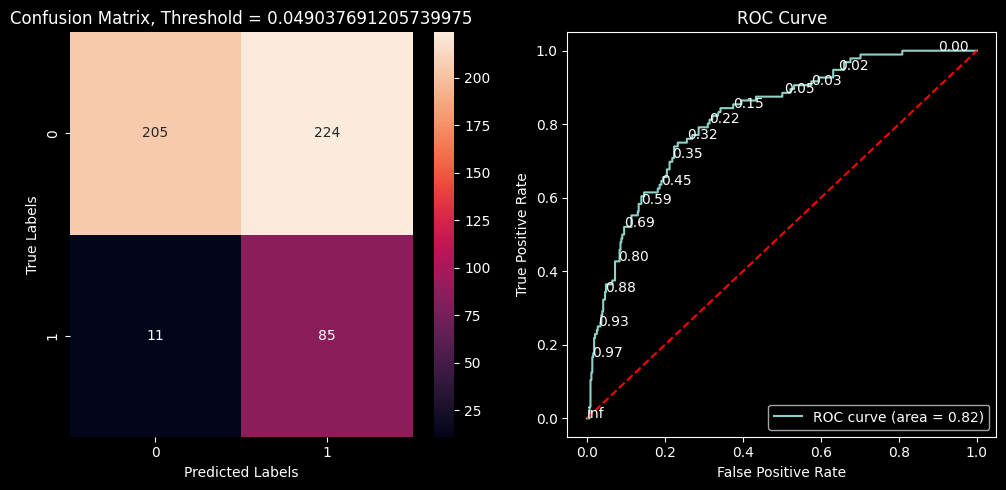

/ / /train/ / / - train_loss 0.5803 - train_spec100 0.0009823 - train_spec90 0.7338 - train_spec80 0.8772 - train_AUC 0.9104 / / /val/ / / - val_loss 0.7451 - val_spec100 0.1911 - val_spec90 0.4779 - val_spec80 0.69 - val_AUC 0.8196 

############################################################################################################## Epoch 60 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.51it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.44it/s]


5 fold performance , epoch 60 :


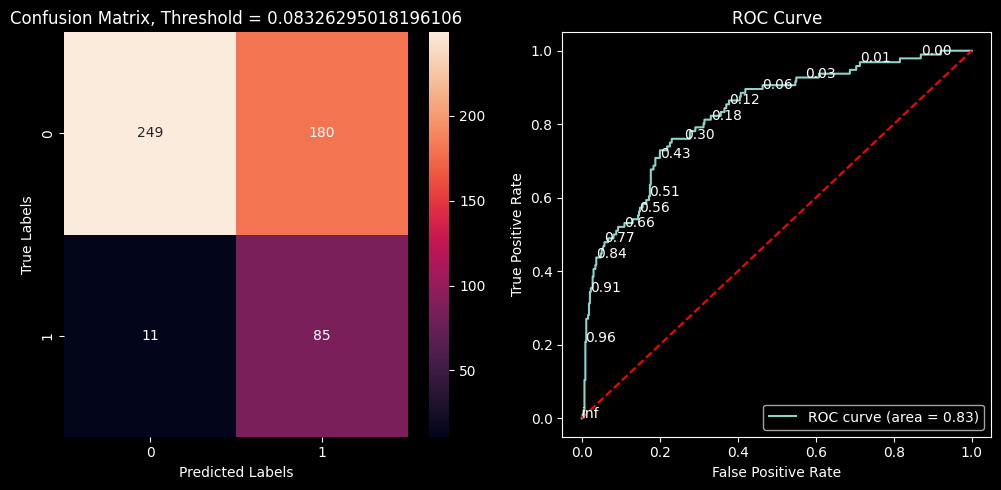

/ / /train/ / / - train_loss 0.5783 - train_spec100 0.006737 - train_spec90 0.7883 - train_spec80 0.8999 - train_AUC 0.9191 / / /val/ / / - val_loss 0.7394 - val_spec100 0.07925 - val_spec90 0.5804 - val_spec80 0.6876 - val_AUC 0.8269 

############################################################################################################## Epoch 61 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.46it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.51it/s]


5 fold performance , epoch 61 :


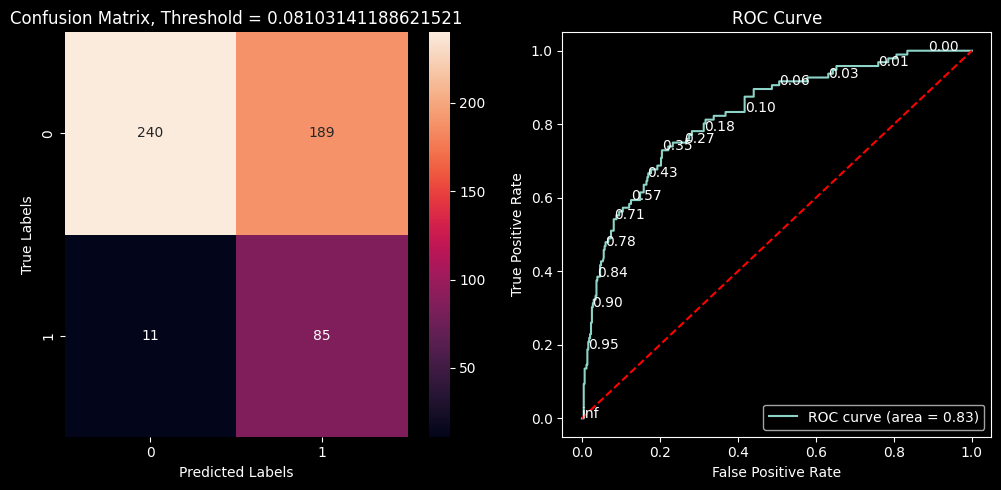

/ / /train/ / / - train_loss 0.5777 - train_spec100 0.002868 - train_spec90 0.7744 - train_spec80 0.9111 - train_AUC 0.9198 / / /val/ / / - val_loss 0.7375 - val_spec100 0.1655 - val_spec90 0.5594 - val_spec80 0.6876 - val_AUC 0.827 

############################################################################################################## Epoch 62 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 62 :


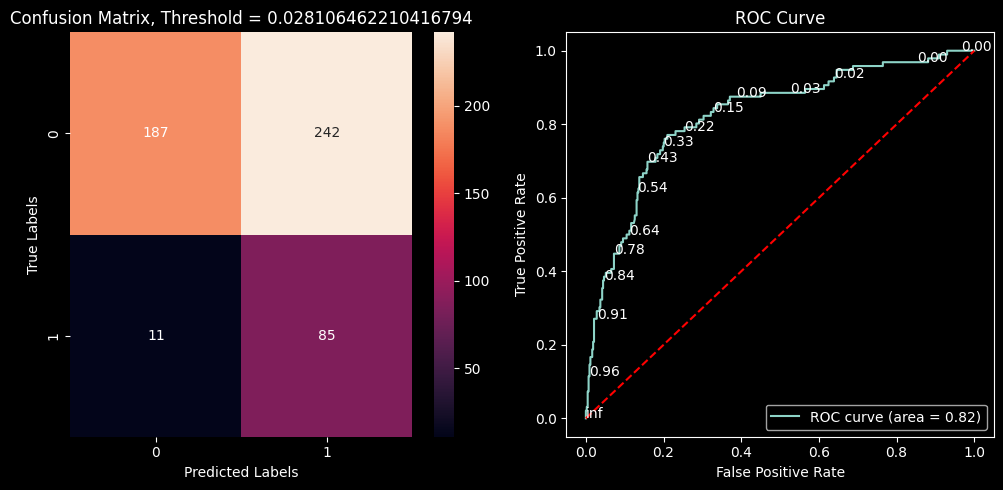

/ / /train/ / / - train_loss 0.577 - train_spec100 0.01258 - train_spec90 0.7773 - train_spec80 0.9061 - train_AUC 0.9278 / / /val/ / / - val_loss 0.7327 - val_spec100 0.06993 - val_spec90 0.4359 - val_spec80 0.7156 - val_AUC 0.8234 

############################################################################################################## Epoch 63 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.35it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


5 fold performance , epoch 63 :


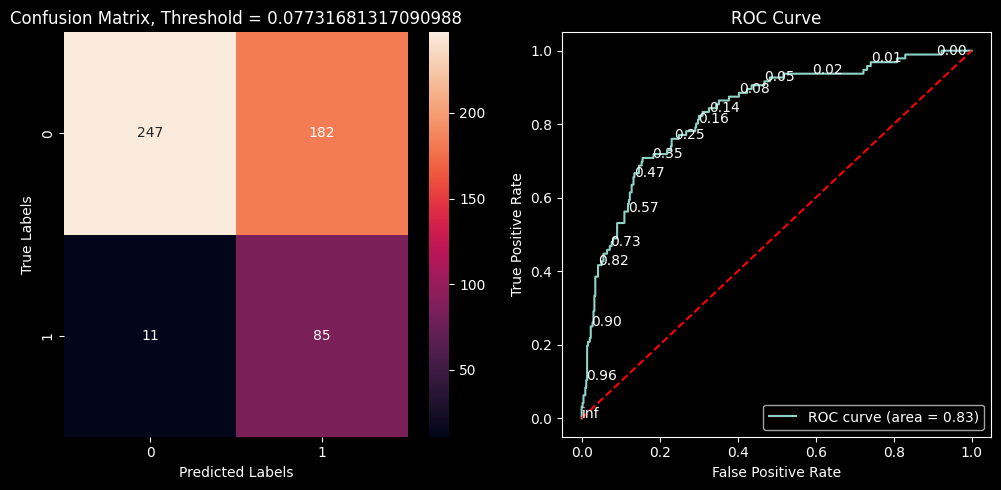

/ / /train/ / / - train_loss 0.5814 - train_spec100 0.0269 - train_spec90 0.7522 - train_spec80 0.8953 - train_AUC 0.9151 / / /val/ / / - val_loss 0.7284 - val_spec100 0.07692 - val_spec90 0.5758 - val_spec80 0.7063 - val_AUC 0.8349 

############################################################################################################## Epoch 64 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


5 fold performance , epoch 64 :


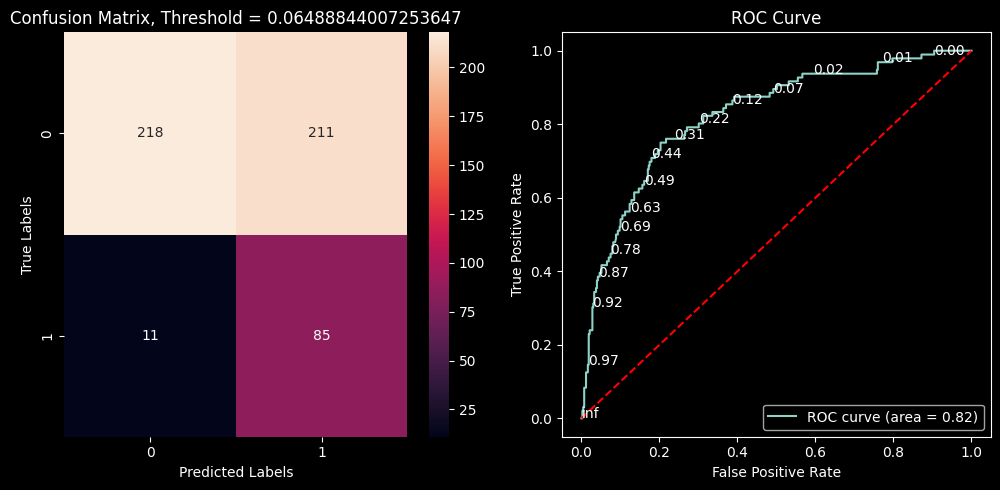

/ / /train/ / / - train_loss 0.5833 - train_spec100 0.03352 - train_spec90 0.7682 - train_spec80 0.9162 - train_AUC 0.9261 / / /val/ / / - val_loss 0.7399 - val_spec100 0.09557 - val_spec90 0.5082 - val_spec80 0.6993 - val_AUC 0.8246 

############################################################################################################## Epoch 65 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 65 :


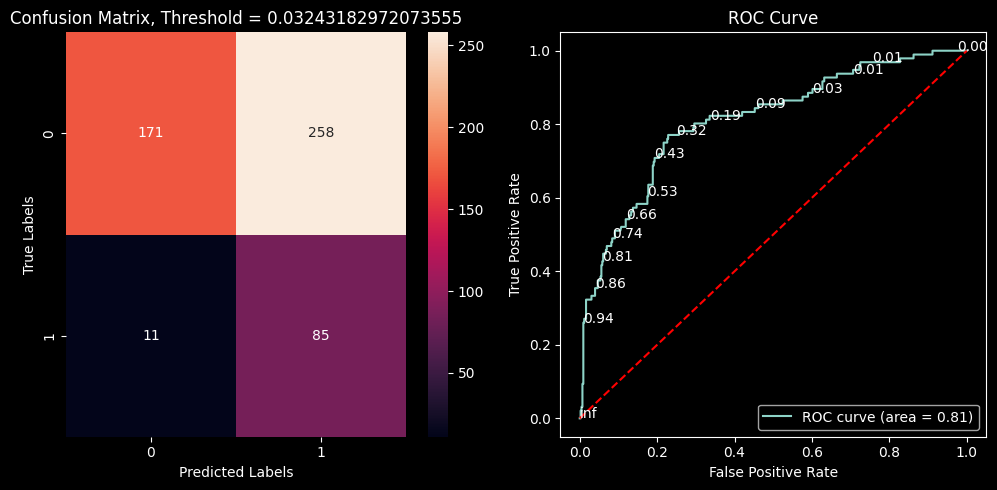

/ / /train/ / / - train_loss 0.5759 - train_spec100 0.0009671 - train_spec90 0.7892 - train_spec80 0.912 - train_AUC 0.9239 / / /val/ / / - val_loss 0.7456 - val_spec100 0.08858 - val_spec90 0.3986 - val_spec80 0.704 - val_AUC 0.8101 

############################################################################################################## Epoch 66 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 66 :


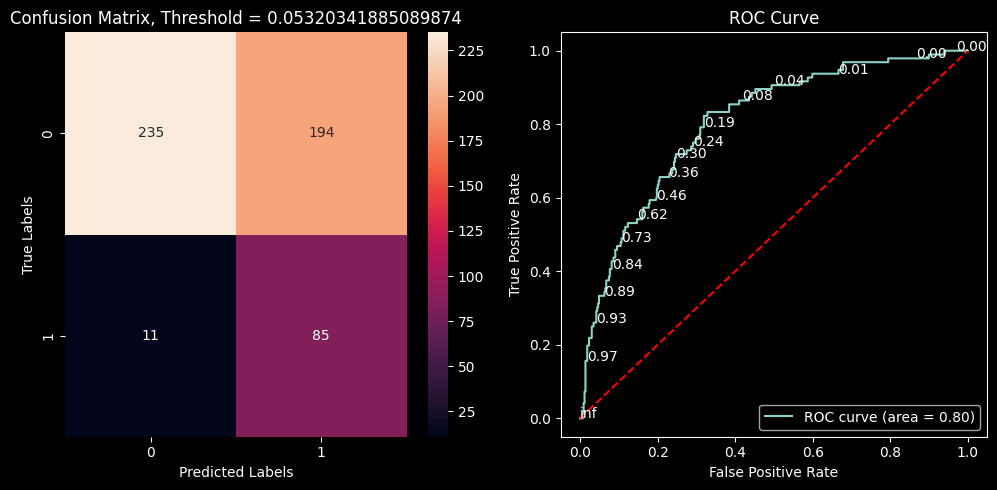

/ / /train/ / / - train_loss 0.5812 - train_spec100 0.004785 - train_spec90 0.7589 - train_spec80 0.9081 - train_AUC 0.9161 / / /val/ / / - val_loss 0.7466 - val_spec100 0.06061 - val_spec90 0.5478 - val_spec80 0.69 - val_AUC 0.8036 

############################################################################################################## Epoch 67 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.42it/s]


5 fold performance , epoch 67 :


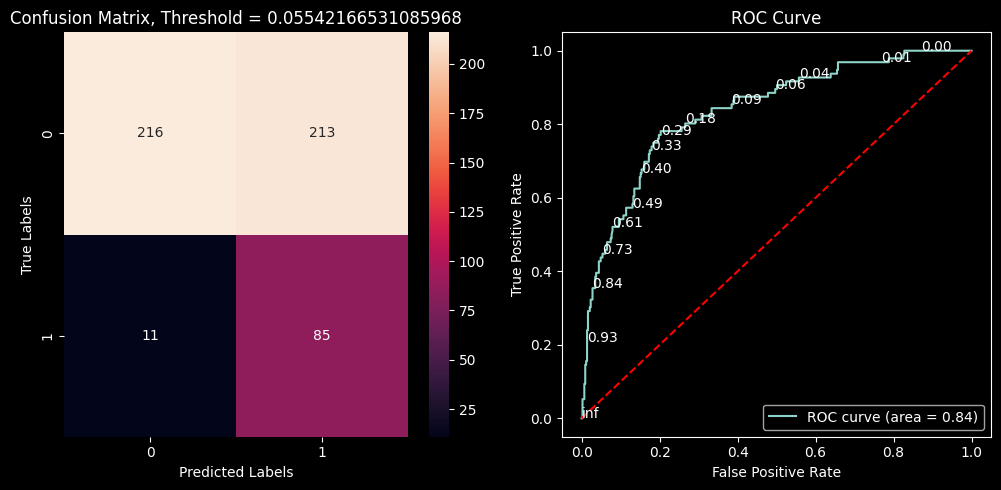

/ / /train/ / / - train_loss 0.58 - train_spec100 0.0421 - train_spec90 0.7792 - train_spec80 0.9224 - train_AUC 0.9268 / / /val/ / / - val_loss 0.7258 - val_spec100 0.1725 - val_spec90 0.5035 - val_spec80 0.7343 - val_AUC 0.8372 

############################################################################################################## Epoch 68 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


5 fold performance , epoch 68 :


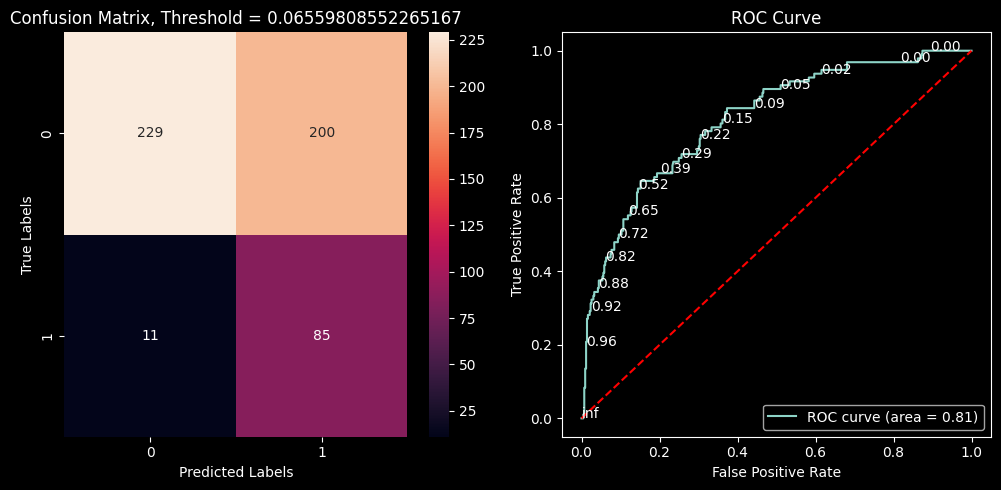

/ / /train/ / / - train_loss 0.5726 - train_spec100 0.03356 - train_spec90 0.8026 - train_spec80 0.9112 - train_AUC 0.9258 / / /val/ / / - val_loss 0.7418 - val_spec100 0.1259 - val_spec90 0.5338 - val_spec80 0.6434 - val_AUC 0.8136 

############################################################################################################## Epoch 69 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 69 :


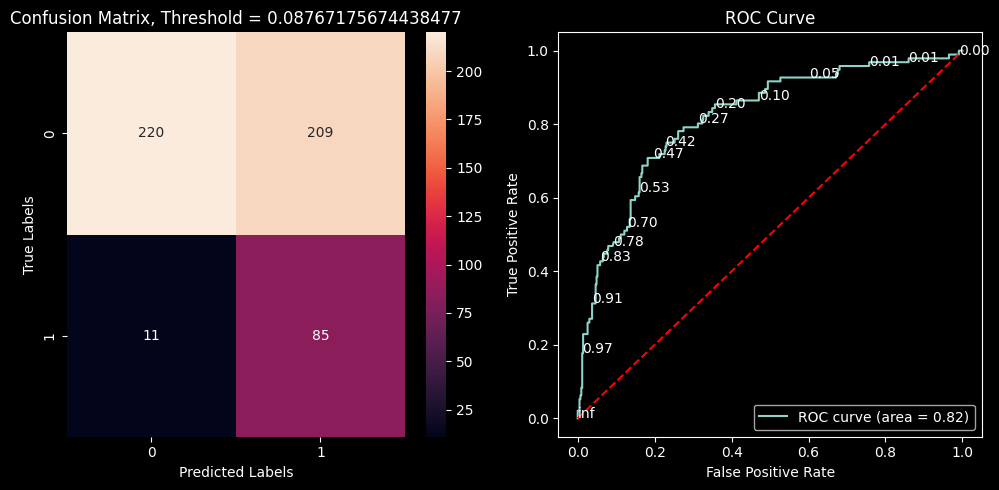

/ / /train/ / / - train_loss 0.5726 - train_spec100 0.1142 - train_spec90 0.7895 - train_spec80 0.8957 - train_AUC 0.9234 / / /val/ / / - val_loss 0.7534 - val_spec100 0.009324 - val_spec90 0.5128 - val_spec80 0.6876 - val_AUC 0.8172 

############################################################################################################## Epoch 70 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.46it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.51it/s]


5 fold performance , epoch 70 :


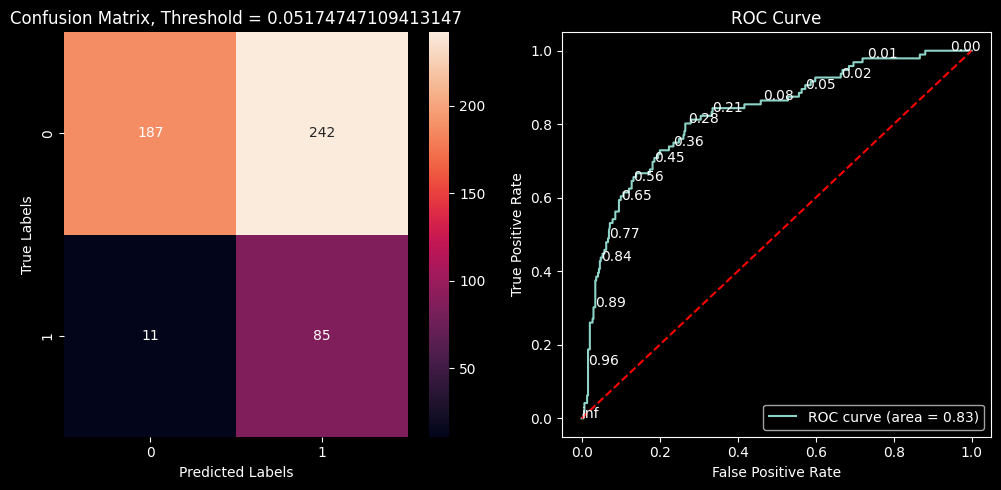

/ / /train/ / / - train_loss 0.5801 - train_spec100 0.0352 - train_spec90 0.7602 - train_spec80 0.9077 - train_AUC 0.924 / / /val/ / / - val_loss 0.7427 - val_spec100 0.1189 - val_spec90 0.4359 - val_spec80 0.7343 - val_AUC 0.8269 

############################################################################################################## Epoch 71 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


5 fold performance , epoch 71 :


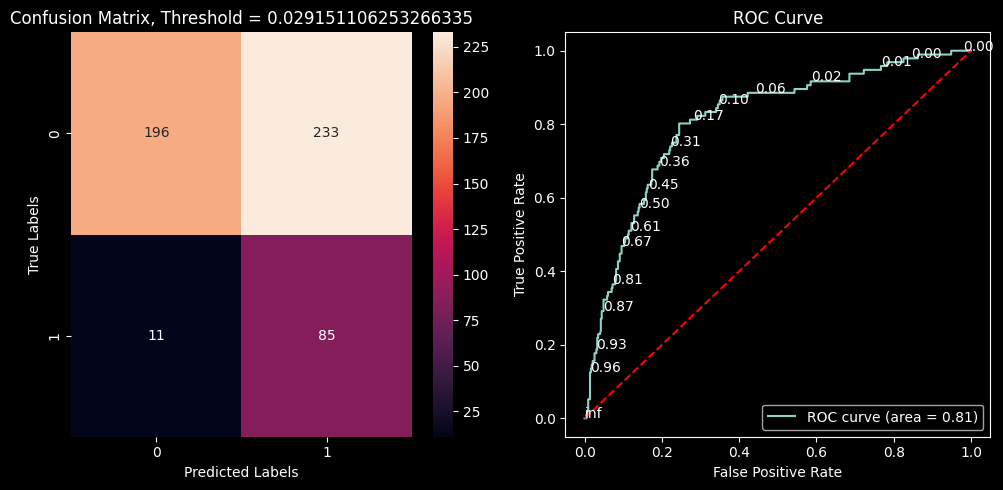

/ / /train/ / / - train_loss 0.5741 - train_spec100 0.0385 - train_spec90 0.794 - train_spec80 0.923 - train_AUC 0.9299 / / /val/ / / - val_loss 0.7349 - val_spec100 0.05128 - val_spec90 0.4569 - val_spec80 0.7552 - val_AUC 0.8112 

############################################################################################################## Epoch 72 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


5 fold performance , epoch 72 :


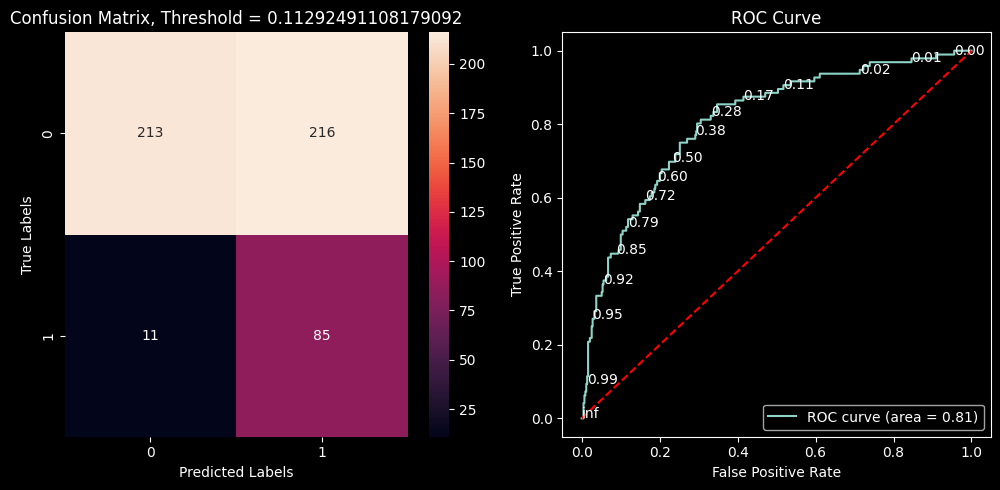

/ / /train/ / / - train_loss 0.5799 - train_spec100 0.01714 - train_spec90 0.7686 - train_spec80 0.9057 - train_AUC 0.9249 / / /val/ / / - val_loss 0.7692 - val_spec100 0.04429 - val_spec90 0.4965 - val_spec80 0.704 - val_AUC 0.8099 

############################################################################################################## Epoch 73 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 73 :


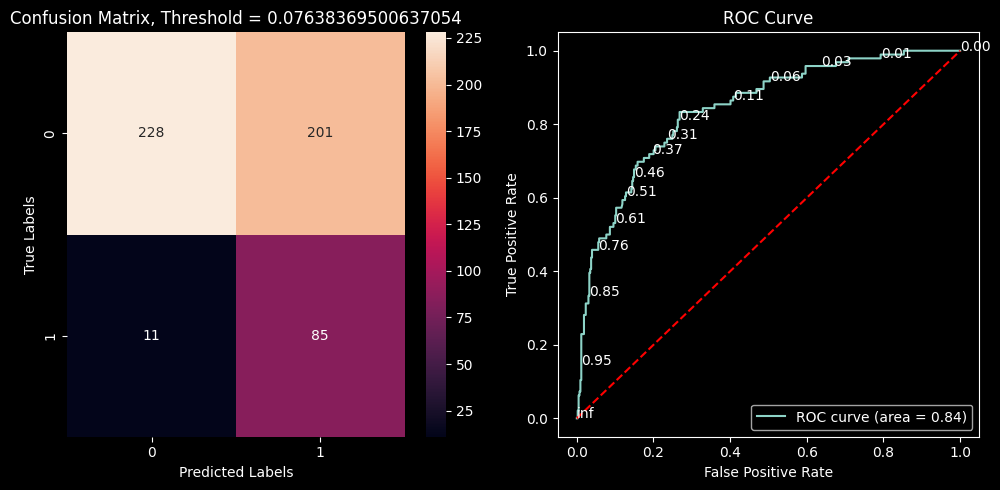

/ / /train/ / / - train_loss 0.5788 - train_spec100 0.01248 - train_spec90 0.7793 - train_spec80 0.9117 - train_AUC 0.9192 / / /val/ / / - val_loss 0.7329 - val_spec100 0.1469 - val_spec90 0.5315 - val_spec80 0.7389 - val_AUC 0.842 

############################################################################################################## Epoch 74 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.47it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 74 :


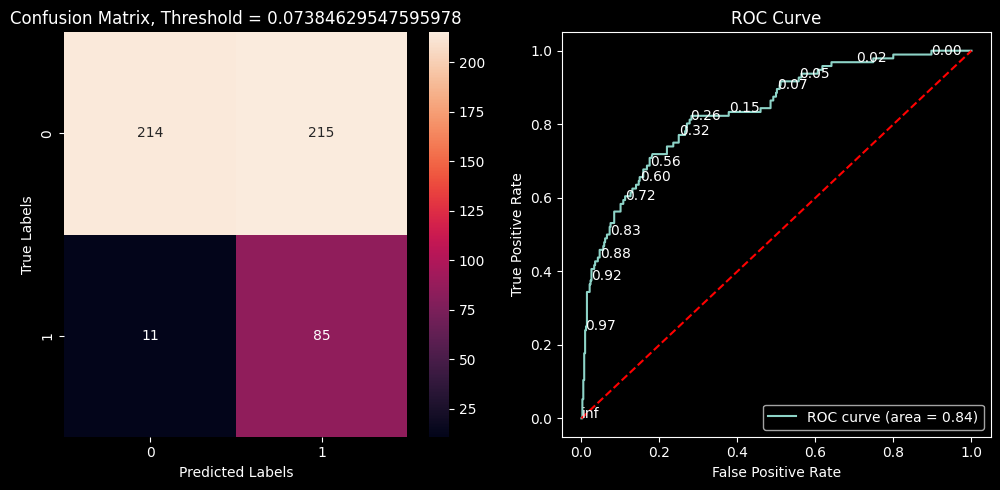

/ / /train/ / / - train_loss 0.5837 - train_spec100 0.03364 - train_spec90 0.7495 - train_spec80 0.9121 - train_AUC 0.9224 / / /val/ / / - val_loss 0.7477 - val_spec100 0.1026 - val_spec90 0.4988 - val_spec80 0.7296 - val_AUC 0.836 

############################################################################################################## Epoch 75 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.47it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 75 :


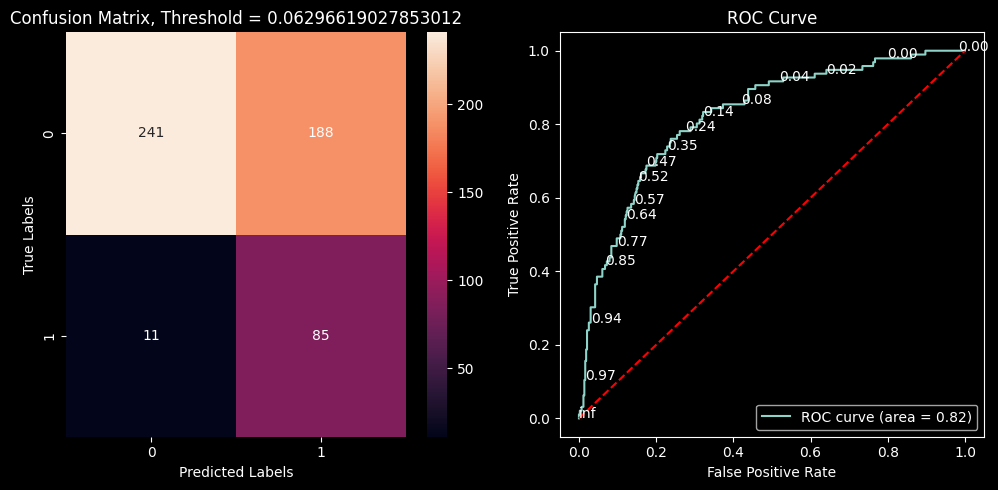

/ / /train/ / / - train_loss 0.5793 - train_spec100 0.05313 - train_spec90 0.8226 - train_spec80 0.9108 - train_AUC 0.9283 / / /val/ / / - val_loss 0.7408 - val_spec100 0.1026 - val_spec90 0.5618 - val_spec80 0.6946 - val_AUC 0.8222 

############################################################################################################## Epoch 76 ####################################################################################################
FOLD 0 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 1 : train


100%|██████████| 27/27 [00:04<00:00,  6.48it/s]


FOLD 2 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


FOLD 3 : train


100%|██████████| 27/27 [00:04<00:00,  6.50it/s]


FOLD 4 : train


100%|██████████| 27/27 [00:04<00:00,  6.49it/s]


5 fold performance , epoch 76 :


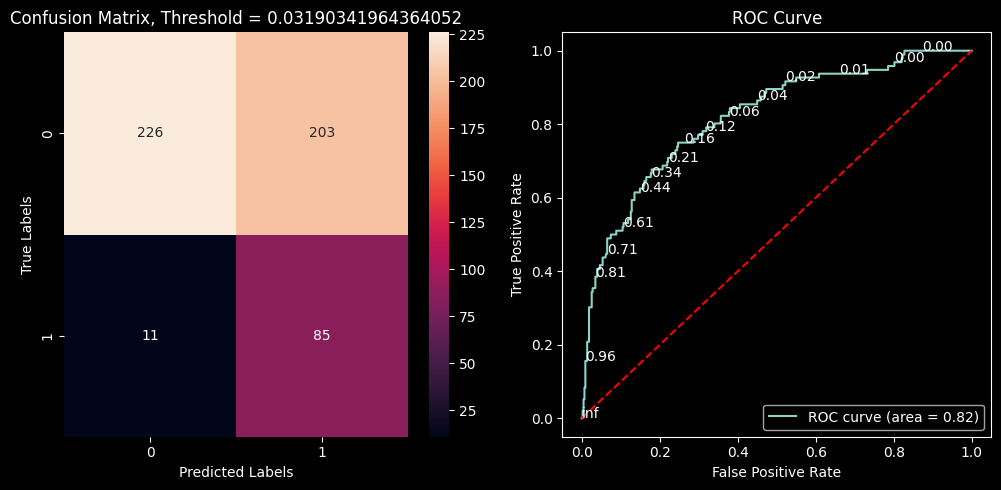

/ / /train/ / / - train_loss 0.5719 - train_spec100 0.05128 - train_spec90 0.8348 - train_spec80 0.9411 - train_AUC 0.9371 / / /val/ / / - val_loss 0.7241 - val_spec100 0.1725 - val_spec90 0.5268 - val_spec80 0.6597 - val_AUC 0.8187 



In [57]:
for epoch in range(n_epochs):
  train_outputs_concat, train_targets_concat, val_outputs_concat, val_targets_concat = [], [], [], []
  print('#'*110 + f' Epoch {epoch+1+epoch_offset} ' + '#'*100)
  for fold, (train_loader, val_loader, model, optimizer) in enumerate(zip(train_folds, val_folds, models_list, optimizers_list)):
    print(f'FOLD {fold} :' , end=' ')

    # training and validation
    train_outputs, train_targets = train_epochs(model, train_loader, optimizer, metrics_list, device)
    val_outputs, val_targets = validate_epochs(model, val_loader, metrics_list, device)
    train_outputs_concat.append(train_outputs), train_targets_concat.append(train_targets), val_outputs_concat.append(val_outputs), val_targets_concat.append(val_targets)

    if fold_performance_analysis:
      fold_performance(model, val_loader, 0.1)
    if save_checkpoints :
      torch.save(obj= {'epoch' : epoch+epoch_offset,
                      'model_state_dict' : model.state_dict(),
                      'optimizer_state_dict' : optimizer.state_dict(),
                      'history' : history},
                f = os.path.join(folder_path, f'{name}_f{fold}_check{epoch+1+epoch_offset}.pth'))

  print(f'5 fold performance , epoch {epoch+1+epoch_offset} :')
  train_outputs_concat, train_targets_concat, val_outputs_concat, val_targets_concat = np.concatenate(train_outputs_concat), np.concatenate(train_targets_concat), np.concatenate(val_outputs_concat), np.concatenate(val_targets_concat)
  train_results = epoch_analysis(train_outputs_concat, train_targets_concat, metrics_list)
  val_results = epoch_analysis(val_outputs_concat, val_targets_concat, metrics_list, display=model_performance_analysis)

  for train_metric, val_metric in zip(train_results, val_results):
    history['train']['train_'+train_metric][epoch+epoch_offset] = train_results[train_metric]
    history['val']['val_'+val_metric][epoch+epoch_offset] = val_results[val_metric]
  epoch_display(history)


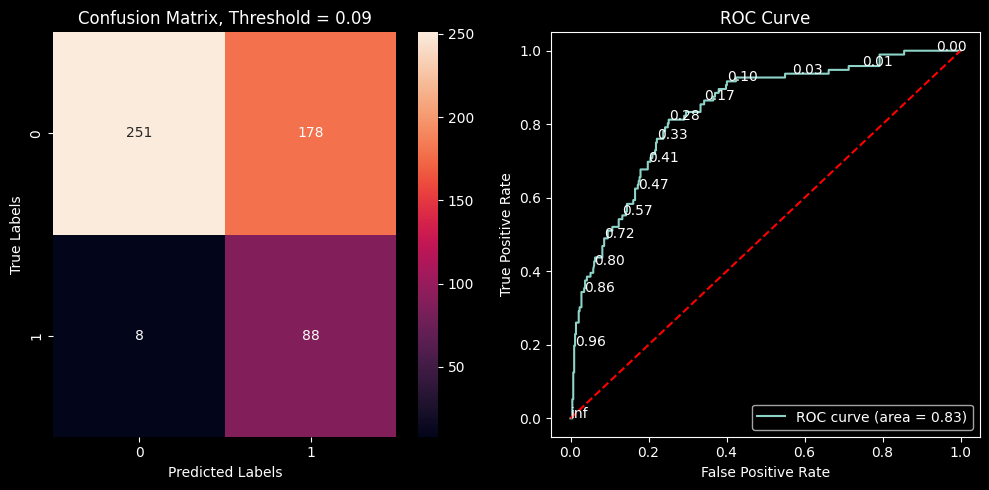

In [61]:
model_performance(models_list, val_folds, threshold=0.09)

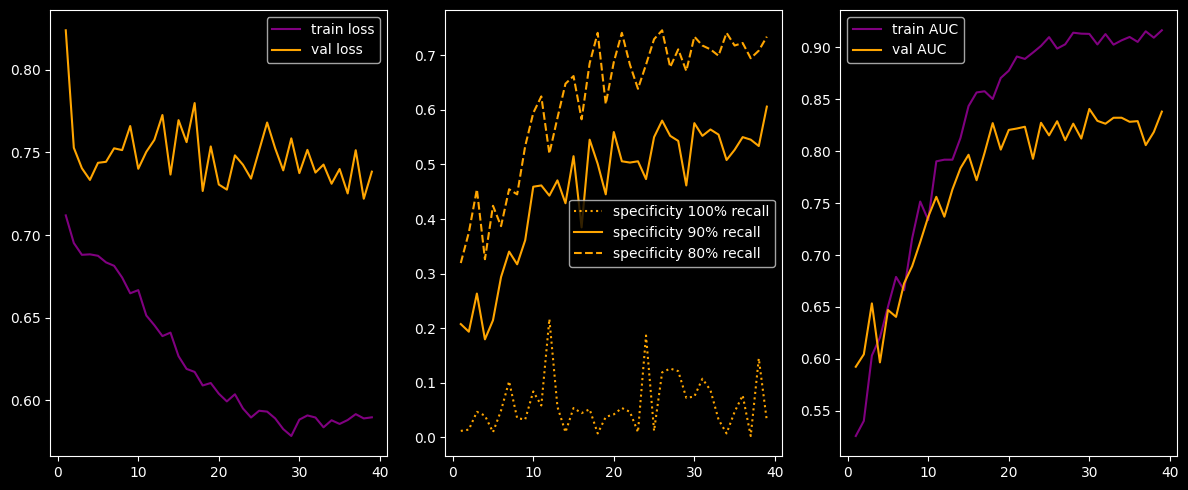

In [60]:
def plot_training_mean_folds(hist_list, metrics_list):
  fig, ax = plt.subplots(1,len(history_list[0]['train']),figsize=(4*len(history_list[0]['train']),5))
  n_epochs, folds = len(history_list[0]['train']['train_loss']), len(history_list)

  for i, metric in enumerate(metrics_list):
    train, val = np.zeros((n_epochs, folds)), np.zeros((n_epochs, folds))

    for history in hist_list:
      train[:,i], val[:,i] = history['train']['train_'+metric], history['val']['val_'+metric]

    ax[i].plot(range(1,n_epochs+1), np.log(np.mean(train, axis=1)), label='train '+metric+' with std', color='purple')
    mean, std = np.mean(val, axis=1), np.std(val, axis=1)
    ax[i].plot(range(1,n_epochs+1), np.log(mean), label='val '+metric, color='orange')
    #ax[i].fill_between(range(1,n_epochs+1), mean-std, mean+std, color='orange', alpha=0.2)
    ax[i].legend()

  plt.tight_layout()
  plt.show()

def plot_training_all_folds(history):
  fig, ax = plt.subplots(1,3, figsize=(4*3,5))
  epochs = range(1,len(history['train']['train_loss'])+1)

  for phase in history:
    ax[0].plot(epochs, history[phase][phase+'_loss'], label=phase+' loss', color='purple' if phase == 'train' else 'orange')
    if phase == 'val':
      ax[1].plot(epochs, history[phase][phase+'_spec100'], label='specificity 100% recall',  color='purple' if phase == 'train' else 'orange', linestyle=':')
      ax[1].plot(epochs, history[phase][phase+'_spec90'], label='specificity 90% recall',  color='purple' if phase == 'train' else 'orange', linestyle='-')
      ax[1].plot(epochs, history[phase][phase+'_spec80'], label='specificity 80% recall',  color='purple' if phase == 'train' else 'orange', linestyle='--')
    ax[2].plot(epochs, history[phase][phase+'_AUC'], label=phase+' AUC', color='purple' if phase == 'train' else 'orange')
  ax[0].legend(),ax[1].legend(),ax[2].legend()
  plt.tight_layout()
  plt.show()


plot_training_all_folds(history)

--------------------------------------------

In [55]:
for fold, model in enumerate(models_list):
  torch.save(obj= {'epoch' : 56,
                        'model_state_dict' : model.state_dict(),
                        'optimizer_state_dict' : optimizer.state_dict(),
                        'history' : history},
                  f = os.path.join(folder_path, f'Resnet_Ensemble_v2_f{fold}_check{56}.pth'))

# Special purpose

In [ ]:
def create_train_test_split(dir_path, test_size=0.2, seed=7):
  # Gets the paths and labels and creates the test set. Only run once!
  image_paths = [0]*len(os.listdir(dir_path))
  labels = [0]*len(image_paths)
  for i, name in enumerate(os.listdir(dir_path)):
    image_paths[i] = os.path.join(dir_path, name)
    labels[i] = 0 if len(name.split(os.sep)[-1].split(' ')) == 2 else 1

  x, x_test, y, y_test = train_test_split(image_paths, labels, test_size=test_size, random_state=seed)
  np.save('/content/drive/MyDrive/StageUCL/Data/x.npy', x)
  np.save('/content/drive/MyDrive/StageUCL/Data/y.npy', y)
  np.save('/content/drive/MyDrive/StageUCL/Data/x_test.npy', x_test)
  np.save('/content/drive/MyDrive/StageUCL/Data/y_test.npy', y_test)
  print('Test set created')
  return 1

create_train_test_split('/content/data_concat')

Test set created


1

# bin

In [ ]:
## Training settings ##
save_checkpoints = False
model_performance_analysis = True
fold_performance_analysis = False

## loss and metrics ##
criterion = torch.nn.BCEWithLogitsLoss().to(device)
metrics_list = {
    'loss': torch.nn.BCEWithLogitsLoss().to(device),
    'prec100': tm.PrecisionAtFixedRecall(task='binary', min_recall=1).to(device),
    'prec85': tm.PrecisionAtFixedRecall(task='binary', min_recall=0.85).to(device),
    'rec': tm.Recall(task='binary').to(device),
    'AUC': tm.AUROC(task='binary').to(device)
}

outputs_history = [[] for _ in range(n_epochs)]
for fold, (train_loader, val_loader, model, optimizer, history) in enumerate(zip(train_folds, val_folds, models_list, optimizers_list, history_list)):
  print('#'*124 + f' FOLD {fold} ' + '#'*124)
  for epoch in range(n_epochs):
    print(f'Epoch {epoch+1+epoch_offset}:', end=' ')

    # training
    base_resnet.train()
    for i, (img_batch, target_batch) in enumerate(tqdm(train_loader)):
      img_batch, target_batch = img_batch.to(device), target_batch.to(device)
      optimizer.zero_grad()
      outputs = base_resnet(img_batch)

      #metrics
      for metric in metrics_list:
        if metric == 'loss':
          metric_value = metrics_list[metric](outputs, target_batch.float())
        else:
          metric_value = metrics_list[metric](outputs, target_batch)
        if isinstance(metric_value, torch.Tensor):
          metric_value = metric_value.item()
        history['train']['train_' + metric][epoch + epoch_offset] += metric_value

      #backward
      loss = criterion(outputs, target_batch.float())
      loss.backward()
      optimizer.step()

    # validation
    base_resnet.eval()
    with torch.no_grad():
      for img_batch, target_batch in val_loader:
        img_batch, target_batch = img_batch.to(device), target_batch.to(device)
        outputs = base_resnet(img_batch)
        outputs_history[epoch].append(outputs)
        for metric in metrics_list:
          if metric == 'loss':
            history['val']['train_'+metric][epoch+epoch_offset] += metrics_list[metric](outputs, target_batch.float())
          else:
            history['val']['train_'+metric][epoch+epoch_offset] += metrics_list[metric](outputs, target_batch)
    for metric in metrics_list:
      history['train']['train_'+metric][epoch+epoch_offset] /= len(train_loader)
      history['val']['val_'+metric][epoch+epoch_offset] /= len(val_loader)

    # Epoch display
    for phase in history:
      print(f'/ / /{phase}/ / /', end=' ')
      for metric in history[phase]:
        print(f'- {metric} {history[phase][metric][epoch+epoch_offset]:.4g}', end=' ')
    print('\n')

    if fold_performance_analysis :
      fold_performance_analysis(base_resnet, val_loader, threshold=0.4)
    if save_checkpoints :
      torch.save(obj= {'epoch' : epoch+epoch_offset,
                      'model_state_dict' : base_resnet.state_dict(),
                      'optimizer_state_dict' : optimizer.state_dict(),
                      'history' : history},
                f = os.path.join(folder_path + '/bin', f'{name}_f{fold}_check{epoch+1+epoch_offset}.pth'))

if model_performance_analysis:
  model_performance_analysis(outputs_history, threshold=0.4)


  if False : #Old code
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, random_state=seed)
    train_dataset = CustomDataset(x_train, y_train, None)
    val_dataset = CustomDataset(x_val, y_val, None)
    test_dataset = CustomDataset(x_test, y_test, None)


    if resample == True:
      class_freqs = [1-(np.sum(y_train)/len(y_train)),np.sum(y_train)/len(y_train)]
      print(f'class frequencies\n0 : {class_freqs[0]:.3g} | 1: {class_freqs[1]:.3g}\nClass sampling weights\n0 : {1/class_freqs[0]:.3g} | 1: {1/class_freqs[1]:.3g}')
      weights = [1/class_freqs[label] for label in y_train]
      train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(y_train), replacement=True)
    else:
      train_sampler = None
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=True if not(resample) else False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    if display == True:
      print("="*50)
      (l_train, n_train), (l_val, n_val), (l_test, n_test) = np.unique(y_train, return_counts=True), np.unique(y_val, return_counts=True), np.unique(y_test, return_counts=True)
      print(f'Train set: {np.sum(n_train)} elements, {100*n_train[1]/np.sum(n_train):.4g}% of deseased cases')
      print(f'Val set: {np.sum(n_val)} elements, {100*n_val[1]/np.sum(n_val):.4g}% of deseased cases')
      print(f'Test set: {np.sum(n_test)} elements, {100*n_test[1]/np.sum(n_test):.4g}% of deseased cases')
      fig, ax = plt.subplots(3,3, figsize=(15,10))
      train_iterator, val_iterator, test_iterator = iter(train_loader), iter(val_loader), iter(test_loader)
      for i in range(3):
        k=np.random.randint(0,batch_size)
        train_imgs, train_labels = next(train_iterator)
        test_imgs, test_labels = next(test_iterator)
        val_imgs, val_labels = next(val_iterator)
        ax[0,i].imshow(train_imgs[k][0,...], cmap='gray') , ax[0,i].set_title(f'Train: {train_labels[k]}'), ax[0,i].axis('off')
        ax[1,i].imshow(test_imgs[k][0,...], cmap='gray') , ax[1,i].set_title(f'Test: {test_labels[k]}'), ax[1,i].axis('off')
        ax[2,i].imshow(val_imgs[k][0,...], cmap='gray') , ax[2,i].set_title(f'Val: {val_labels[k]}'), ax[2,i].axis('off')
      plt.show()
